# Import required packages

In [1]:
## Standard libraries
import os
import numpy as np
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy
import pickle
import re

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN
from torchvision import transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
pl.seed_everything(42)

# Import tensorboard
%load_ext tensorboard

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


# Set folder paths

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "raw_data/seed-v/merged_data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/seed-v"

# Define dataset class for SEEDV and initialize a new dataset

In [3]:
class SEEDV(data.Dataset):
    def __init__(self, emotion_dict: dict, num_subjects: int, data_path: str):
        """constructor for SEEDV dataset

        Args:
            emotion_dict (dict): dictionary of emotion_num as key and
            emotion_str as value
            num_subjects (int): number of subjects in the dataset
            data_path (str): path to the directory containing npy data files
        """
        self.emotion_dict = emotion_dict
        self.num_subjects = num_subjects
        self.data_path = data_path
        self.tensor_dataset = self.load_data()

    def load_data(self):
        """load data from npy files to create tensor dataset

        Returns:
            data.TensorDataset: tensor dataset containing 
                all data from all npy files
        """
        # initialize dataset and subjects to None at start
        dataset = None
        subjects = None

        # loop through all files in the directory
        for file in os.listdir(self.data_path):
            # get the file path of the file
            file_path = os.path.join(self.data_path, file)

            # get subject number from the filename
            s_num = np.int64(re.findall("\d+", file)[0]) - 1

            # if dataset has not been created yet
            if dataset is None:
                # create subject meta labels for each sample in dataset
                for i in range(len(np.load(file_path))):
                    if subjects is None:
                        subjects = s_num
                    else:
                        # need to hstack subjects to match tensor shapes of emotion
                        subjects = np.hstack((subjects, s_num))
                # load the data from the npy file
                dataset = np.load(file_path)
            # else if dataset already exists
            else:
                for i in range(len(np.load(file_path))):
                    # hstack subjects to match tensor shapes of emotion
                    subjects = np.hstack((subjects, s_num))
                # stack the data vertically
                dataset = np.vstack((dataset, np.load(file_path)))

        # create tensor dataset with subject meta labels, features, and emotion labels
        tensor_dataset = data.TensorDataset(torch.from_numpy(
            subjects), torch.from_numpy(dataset[:, :-1]), torch.from_numpy(dataset[:, -1]))

        return tensor_dataset

    def get_subjects_data(self, s_nums: list):
        """get data for only subjects in s_nums

        Args:
            s_nums (list): list of subject numbers that identifies subjects

        Returns:
            tuple of torch.tensor: all features and all emotion numbers for only
            specified subjects
        """
        all_features = None
        all_emotions = None

        for s_num in s_nums:
            if all_features == None:
                all_features, all_emotions = self.__getitem__(s_num)
            else:
                features, targets = self.__getitem__(s_num)
                all_features = torch.vstack((all_features, features))
                all_emotions = torch.vstack((all_emotions, targets))

        return all_features, all_emotions.reshape((1,-1))[0]

    def __len__(self):
        """get number of samples in dataset

        Returns:
            int: number of samples in dataset
        """
        return len(self.tensor_dataset)

    def __getitem__(self, s_num: int):
        """get data for a given s_num

        Args:
            s_num (int): number that identifies a subject

        Returns:
            tuple of torch.tensor: features and corresponding emotion numbers
        """
        indices = torch.where(self.tensor_dataset[:][0] == s_num, True, False)
        features = self.tensor_dataset[indices][1]
        emotion_num = self.tensor_dataset[indices][2]

        return features, emotion_num.to(torch.int64).reshape((1,-1))[0]


In [4]:
seed_v = SEEDV(emotion_dict = {0: 'disgust', 1: 'fear', 2: 'sad', 3: 'neutral', 4: 'happy'}, num_subjects=16, data_path=DATASET_PATH)

# Perform a train-val-test split by label

In [5]:
metaclasses = torch.randperm(16) # random permutation of subjects 0 to 15 which are the metaclasses
train_metaclasses, val_metaclasses, test_metaclasses = metaclasses[0:12], metaclasses[12:14], metaclasses[14:16]

In [6]:
class EEGDataset(data.Dataset):
    def __init__(self, features, targets):
        """constructor for EEGDataset"""
        super().__init__()
        self.features = features
        self.targets = targets

    def __getitem__(self, idx):
        """get item by index"""
        features, targets = self.features[idx], self.targets[idx]

        return features, targets

    def __len__(self):
        """get number of samples in dataset"""
        return self.features.shape[0]

In [7]:
train_set = EEGDataset(*seed_v.get_subjects_data(train_metaclasses))
val_set = EEGDataset(*seed_v.get_subjects_data(val_metaclasses))
test_set = EEGDataset(*seed_v.get_subjects_data(test_metaclasses))

In [8]:
train_set.targets.shape

torch.Size([21876])

# Setup dataloaders and samplers

In [9]:
class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which 
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but 
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in 
                           the beginning, but kept constant across iterations 
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot
        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        # self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            # self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for 
        # training and validation, this is not a problem.
        # random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            # Select N classes for the batch
            # class_batch = self.class_list[it*self.N_way:(it+1)*self.N_way]  #
            
            # WARNING: Possible problem with this is that the last batch might
            # not have all N classes
            class_batch = random.sample(self.classes, self.N_way)
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c]:start_index[c]+self.K_shot])
                start_index[c] += self.K_shot
                try:
                    self.indices_per_class[c][start_index[c]]
                except:
                    start_index[c] = 0
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

In [10]:
N_WAY = 5
K_SHOT = 10
train_data_loader = data.DataLoader(train_set,
                                    batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                      include_query=True,
                                                                      N_way=N_WAY,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=True),
                                    num_workers=32)
val_data_loader = data.DataLoader(val_set,
                                  batch_sampler=FewShotBatchSampler(val_set.targets,
                                                                    include_query=True,
                                                                    N_way=N_WAY,
                                                                    K_shot=K_SHOT,
                                                                    shuffle=False,
                                                                    shuffle_once=True),
                                  num_workers=32)

# Split batch into query and support

In [11]:
def split_query_support(features, targets):
    support_features, query_features = features.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_features, query_features, support_targets, query_targets

In [12]:
features, targets = next(iter(val_data_loader))
support_features, query_features, support_targets, query_targets = split_query_support(features, targets)

# Normalize and visualize the features in batch

In [13]:
# Normalize the features
support_features = support_features / support_features.max(0, keepdim=True)[0]
query_features = query_features / query_features.max(0, keepdim=True)[0]

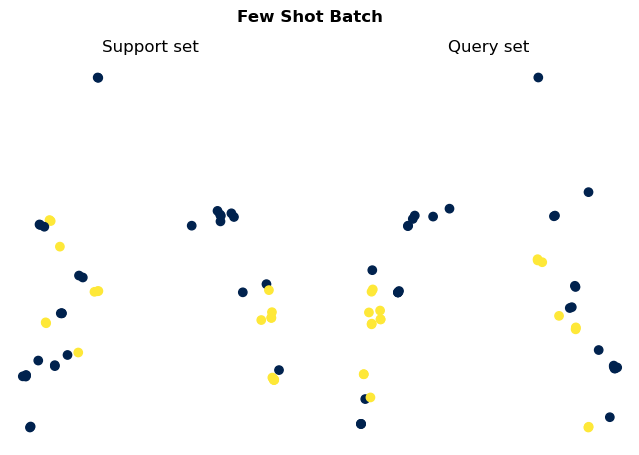

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
support_pca = pca.fit_transform(support_features)
query_pca = pca.fit_transform(query_features)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(support_pca[:,0], support_pca[:,1], c=support_targets.reshape((-1,1)))
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].scatter(query_pca[:,0], query_pca[:,1], c=query_targets.reshape((-1,1)))
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show()
plt.close()

# Define DCCA neural network used in SEEDV paper

## Define CCA methods and classes

In [15]:
def cca_metric_derivative(H1, H2):
    r1 = 1e-3
    r2 = 1e-3
    eps = 1e-9
    # transform the matrix: to be consistent with the original paper
    H1 = H1.T
    H2 = H2.T
    # o1 and o2 are feature dimensions
    # m is sample number
    o1 = o2 = H1.shape[0]
    m = H1.shape[1]

    # calculate parameters
    H1bar = H1 - H1.mean(axis=1).reshape([-1,1])
    H2bar = H2 - H2.mean(axis=1).reshape([-1,1])

    SigmaHat12 = (1.0 / (m - 1)) * np.matmul(H1bar, H2bar.T)
    SigmaHat11 = (1.0 / (m - 1)) * np.matmul(H1bar, H1bar.T) + r1 * np.eye(o1)
    SigmaHat22 = (1.0 / (m - 1)) * np.matmul(H2bar, H2bar.T) + r2 * np.eye(o2)

    # eigenvalue and eigenvector decomposition
    [D1, V1] = np.linalg.eigh(SigmaHat11)
    [D2, V2] = np.linalg.eigh(SigmaHat22)

    # remove eighvalues and eigenvectors smaller than 0
    posInd1 = np.where(D1 > 0)[0]
    D1 = D1[posInd1]
    V1 = V1[:, posInd1]

    posInd2 = np.where(D2 > 0)[0]
    D2 = D2[posInd2]
    V2 = V2[:, posInd2]

    # calculate matrxi T
    SigmaHat11RootInv = np.matmul(np.matmul(V1, np.diag(D1 ** -0.5)), V1.T)
    SigmaHat22RootInv = np.matmul(np.matmul(V2, np.diag(D2 ** -0.5)), V2.T)
    Tval = np.matmul(np.matmul(SigmaHat11RootInv,SigmaHat12), SigmaHat22RootInv)
    # By default, we will use all the singular values
    tmp = np.matmul(Tval.T, Tval)
    corr = np.sqrt(np.trace(tmp))
    cca_loss = -1 * corr

    # calculate the derivative of H1 and H2
    U_t, D_t, V_prime_t = np.linalg.svd(Tval)
    Delta12 = SigmaHat11RootInv @ U_t @ V_prime_t @ SigmaHat22RootInv
    Delta11 = SigmaHat11RootInv @ U_t @ np.diag(D_t) @ U_t.T @ SigmaHat11RootInv
    Delta22 = SigmaHat22RootInv @ U_t @ np.diag(D_t) @ U_t.T @ SigmaHat22RootInv
    Delta11 = -0.5 * Delta11
    Delta22 = -0.5 * Delta22

    DerivativeH1 = ( 1.0 / (m - 1)) * (2 * (Delta11 @ H1bar) + Delta12 @ H2bar)
    DerivativeH2 = ( 1.0 / (m - 1)) * (2 * (Delta22 @ H2bar) + Delta12 @ H1bar)

    return cca_loss, DerivativeH1.T, DerivativeH2.T

## Define DCCA network layers

In [16]:
class TransformLayers(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super(TransformLayers, self).__init__()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    #nn.BatchNorm1d(num_features=layer_sizes[l_id], affine=False),
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id+1]),
                    ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id+1]),
                    nn.Sigmoid(),
                    #nn.BatchNorm1d(num_features=layer_sizes[l_id+1], affine=False),
                    ))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class AttentionFusion(nn.Module):
    def __init__(self, output_dim):
        super(AttentionFusion, self).__init__()
        self.output_dim = output_dim
        self.attention_weights = nn.Parameter(torch.randn(self.output_dim, requires_grad=True))
    def forward(self, x1, x2):
        # calculate weigths for all input samples
        row, _ = x1.shape
        fused_tensor = torch.empty_like(x1)
        alpha = []
        for i in range(row):
            tmp1 = torch.dot(x1[i,:], self.attention_weights)
            tmp2 = torch.dot(x2[i,:], self.attention_weights)
            alpha_1 = torch.exp(tmp1) / (torch.exp(tmp1) + torch.exp(tmp2))
            alpha_2 = 1 - alpha_1
            alpha.append((alpha_1.detach().cpu().numpy(), alpha_2.detach().cpu().numpy()))
            fused_tensor[i, :] = alpha_1 * x1[i,:] + alpha_2 * x2[i, :]
        return fused_tensor, alpha

class DCCA_AM(nn.Module):
    def __init__(self, input_size1, input_size2, layer_sizes1, layer_sizes2, outdim_size, categories, device):
        super(DCCA_AM, self).__init__()
        self.input_dim_split = input_size1
        self.outdim_size = outdim_size
        self.categories = categories
        # self.use_all_singular_values = use_all_singular_values
        self.device = device

        self.model1 = TransformLayers(input_size1, layer_sizes1).to(self.device)
        self.model2 = TransformLayers(input_size2, layer_sizes2).to(self.device)

        # convert generator object to list for deepcopy(model) to work
        self.model1_parameters = list(self.model1.parameters()) 
        self.model2_parameters = list(self.model2.parameters())

        self.classification = nn.Linear(self.outdim_size, self.categories)

        self.attention_fusion = AttentionFusion(outdim_size)
    def forward(self, x):
        x1 = x[:, :self.input_dim_split]
        x2 = x[:, self.input_dim_split:]
        # forward process: returns negative of cca loss and predicted labels
        output1 = self.model1(x1)
        output2 = self.model2(x2)
        # cca_loss_val = self.loss(output1, output2)
        cca_loss, partial_h1, partial_h2 = cca_metric_derivative(output1.detach().cpu().numpy(), output2.detach().cpu().numpy())
        fused_tensor, alpha = self.attention_fusion(output1, output2)
        out = self.classification(fused_tensor)
        return out, cca_loss, output1, output2, partial_h1, partial_h2, fused_tensor.detach().cpu().data, alpha

# Define meta learning model and methods

## Define baseline ProtoNet model

In [17]:
class ProtoNet(pl.LightningModule):

    def __init__(self, lr, model_args):
        """
        Inputs
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of Adam optimizer
        """
        super().__init__()
        self.save_hyperparameters()
        eeg_input_dim, eye_input_dim, layer_sizes1, layer_sizes2, \
            output_dim, num_emotions, device = model_args
        self.model = DCCA_AM(eeg_input_dim, eye_input_dim, layer_sizes1, layer_sizes2, output_dim, num_emotions, device).to(device)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        features = features[0]
        # targets = targets.reshape((1,-1))[0] 
        # already RESHAPED EARLIER in dataset_from_labels call
        classes, _ = torch.unique(targets).sort() # Determine which classes we have
        prototypes = []
        # print("targets:", targets)
        for c in classes:
            # print("c:", c)
            # print(features[torch.where(targets == c)[0]])
            # maybe use for target in targets loop
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        # Return the 'classes' tensor to know which prototype belongs to which class
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc

    def calculate_loss(self, batch, mode):
        # Determine training loss for a given support and query set 
        features, targets = batch
        outputs = self.model(features)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_query_support(outputs, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)

        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        _ = self.calculate_loss(batch, mode="val")

## Define ProtoMAML model

In [18]:
class ProtoMAML(pl.LightningModule):
    
    def __init__(self, lr, lr_inner, lr_output, num_inner_steps, model_args):
        """
        Inputs
            eeg_input_dim - Dimensionality of prototype feature space
            lr - Learning rate of the outer loop Adam optimizer
            lr_inner - Learning rate of th``e inner loop SGD optimizer
            lr_output - Learning rate for the output layer in the inner loop
            num_inner_steps - Number of inner loop updates to perform
        """
        super().__init__()
        self.save_hyperparameters()
        eeg_input_dim, eye_input_dim, layer_sizes1, layer_sizes2, \
            output_dim, num_emotions, device = model_args
        self.model = DCCA_AM(eeg_input_dim, eye_input_dim, layer_sizes1, layer_sizes2, output_dim, num_emotions, device).to(device)
        
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140,180], gamma=0.1)
        return [optimizer], [scheduler]
        
    def run_model(self, local_model, output_weight, output_bias, features, labels):
        # Execute a model with given output layer weights and inputs
        dcca_out = local_model(features)
        out = dcca_out[0]
        cca_loss = dcca_out[1]
        # get only first element of tuple in feats
        preds = F.linear(out, output_weight, output_bias)
        # loss = F.cross_entropy(preds, labels.reshape((-1,1))[0]) 
        # already RESHAPED EARLIER in dataset_from_labels calls
        loss = 0.7 * cca_loss + 1.0 * F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float()
        return loss, preds, acc
        
    def adapt_few_shot(self, support_features, support_targets):
        # Determine prototype initialization
        support_preds = self.model(support_features)
        prototypes, classes = ProtoNet.calculate_prototypes(support_preds, support_targets)
        support_labels = (classes[None,:] == support_targets[:,None]).long().argmax(dim=-1)
        # Create inner-loop model and optimizer
        local_model = deepcopy(self.model)
        local_model.train()
        local_optim = optim.SGD(local_model.parameters(), lr=self.hparams.lr_inner)
        local_optim.zero_grad()
        # Create output layer weights with prototype-based initialization
        init_weight = 2 * prototypes
        init_bias = -torch.norm(prototypes, dim=1)**2
        output_weight = init_weight.detach().requires_grad_()
        output_bias = init_bias.detach().requires_grad_()
        
        # Optimize inner loop model on support set
        for _ in range(self.hparams.num_inner_steps):
            # Determine loss on the support set
            # print(support_labels)
            loss, _, _ = self.run_model(local_model, output_weight, output_bias, support_features, support_labels)
            # Calculate gradients and perform inner loop update
            loss.backward()
            local_optim.step()
            # Update output layer via SGD
            output_weight.data -= self.hparams.lr_output * output_weight.grad
            output_bias.data -= self.hparams.lr_output * output_bias.grad
            # Reset gradients
            local_optim.zero_grad()
            output_weight.grad.fill_(0)
            output_bias.grad.fill_(0)
            
        # Re-attach computation graph of prototypes
        output_weight = (output_weight - init_weight).detach() + init_weight
        output_bias = (output_bias - init_bias).detach() + init_bias
        
        return local_model, output_weight, output_bias, classes
        
    def outer_loop(self, batch, mode="train"):
        accuracies = []
        losses = []
        self.model.zero_grad()
        
        # Determine gradients for batch of tasks
        for task_batch in batch:
            features, targets = task_batch
            support_features, query_features, support_targets, query_targets = split_query_support(features, targets)
            # Perform inner loop adaptation
            # print(support_targets)
            local_model, output_weight, output_bias, classes = self.adapt_few_shot(support_features, support_targets)
            # Determine loss of query set
            query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)
            loss, preds, acc = self.run_model(local_model, output_weight, output_bias, query_features, query_labels)
            # Calculate gradients for query set loss
            if mode == "train":
                loss.backward()

                for p_global, p_local in zip(self.model.parameters(), local_model.parameters()):
                    p_global.grad += p_local.grad  # First-order approx. -> add gradients of finetuned and base model
            
            accuracies.append(acc.mean().detach())
            losses.append(loss.detach())
        
        # Perform update of base model
        if mode == "train":
            opt = self.optimizers()
            opt.step()
            opt.zero_grad()
        
        self.log(f"{mode}_loss", sum(losses) / len(losses))
        self.log(f"{mode}_acc", sum(accuracies) / len(accuracies))
    
    def training_step(self, batch, batch_idx):
        self.outer_loop(batch, mode="train")
        return None  # Returning None means we skip the default training optimizer steps by PyTorch Lightning
        
    def validation_step(self, batch, batch_idx):
        # Validation requires to finetune a model, hence we need to enable gradients
        torch.set_grad_enabled(True)
        self.outer_loop(batch, mode="val")
        torch.set_grad_enabled(False)

## Define task batch sampler

In [19]:
class TaskBatchSampler(object):
    
    def __init__(self, dataset_targets, batch_size, N_way, K_shot, include_query=False, shuffle=True):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            batch_size - Number of tasks to aggregate in a batch
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which 
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but 
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
        """
        super().__init__()
        self.batch_sampler = FewShotBatchSampler(dataset_targets, N_way, K_shot, include_query, shuffle)
        self.task_batch_size = batch_size
        self.local_batch_size = self.batch_sampler.batch_size
        
    def __iter__(self):
        # Aggregate multiple batches before returning the indices
        batch_list = []
        for batch_idx, batch in enumerate(self.batch_sampler):
            batch_list.extend(batch)
            if (batch_idx+1) % self.task_batch_size == 0:
                yield batch_list
                batch_list = []
        
    def __len__(self):
        return len(self.batch_sampler)//self.task_batch_size
    
    def get_collate_fn(self):
        # Returns a collate function that converts one big tensor into a list of task-specific tensors
        def collate_fn(item_list):
            features = torch.stack([feat for feat, target in item_list], dim=0)
            targets = torch.stack([target for feat, target in item_list], dim=0)
            features = features.chunk(self.task_batch_size, dim=0)
            targets = targets.chunk(self.task_batch_size, dim=0)
            return list(zip(features, targets))
        return collate_fn

## Define model training and testing methods

In [20]:
def train_model(model_class, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=50,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc", every_n_epochs=1),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         log_every_n_steps=12)
    trainer.logger._default_hp_metric = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(
        CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = model_class(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

def test_protomaml(model, dataset, k_shot=4):
    pl.seed_everything(42)
    model = model.to(device)
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes
    
    # Data loader for full test set as query set
    full_dataloader = data.DataLoader(dataset, 
                                      batch_size=128, 
                                      num_workers=32, 
                                      shuffle=False, 
                                      drop_last=False)
    # Data loader for sampling support sets
    sampler = FewShotBatchSampler(dataset.targets, 
                                  include_query=False,
                                  N_way=num_classes,
                                  K_shot=k_shot,
                                  shuffle=False,
                                  shuffle_once=False)
    sample_dataloader = data.DataLoader(dataset, 
                                        batch_sampler=sampler,
                                        num_workers=32)
    
    # We iterate through the full dataset in two manners. First, to select the k-shot batch. 
    # Second, the evaluate the model on all other examples
    accuracies = []
    for (support_features, support_targets), support_indices in tqdm(zip(sample_dataloader, sampler), "Performing few-shot finetuning"):
        support_features = support_features.to(device)
        support_targets = support_targets.to(device)
        try:
            # Finetune new model on support set
            local_model, output_weight, output_bias, classes = model.adapt_few_shot(support_features, support_targets)
            with torch.no_grad():  # No gradients for query set needed
                local_model.eval()
                batch_acc = torch.zeros((0,), dtype=torch.float32, device=device)
                # Evaluate all examples in test dataset
                for query_features, query_targets in full_dataloader:
                    query_features = query_features.to(device)
                    query_targets = query_targets.to(device)
                    query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)
                    _, _, acc = model.run_model(local_model, output_weight, output_bias, query_features, query_labels)
                    batch_acc = torch.cat([batch_acc, acc.detach()], dim=0)
                # Exclude support set elements
                for s_idx in support_indices:
                    batch_acc[s_idx] = 0
                batch_acc = batch_acc.sum().item() / (batch_acc.shape[0] - len(support_indices))
                accuracies.append(batch_acc)
        except np.linalg.LinAlgError:
            print("NaN layer encountered")
    return mean(accuracies), stdev(accuracies)

# Train meta learning model

In [24]:
# Training constant (same as for ProtoNet)
N_WAY = 5
K_SHOT = 10

# Training set
train_protomaml_sampler = TaskBatchSampler(train_set.targets, 
                                           include_query=True,
                                           N_way=N_WAY,
                                           K_shot=K_SHOT,
                                           batch_size=16)
train_protomaml_loader = data.DataLoader(train_set, 
                                         batch_sampler=train_protomaml_sampler,
                                         collate_fn=train_protomaml_sampler.get_collate_fn(),
                                         num_workers=32)

# Validation set
val_protomaml_sampler = TaskBatchSampler(val_set.targets, 
                                         include_query=True,
                                         N_way=N_WAY,
                                         K_shot=K_SHOT,
                                         batch_size=1,  # We do not update the parameters, hence the batch size is irrelevant here
                                         shuffle=False)
val_protomaml_loader = data.DataLoader(val_set, 
                                       batch_sampler=val_protomaml_sampler,
                                       collate_fn=val_protomaml_sampler.get_collate_fn(),
                                       num_workers=32)

In [32]:
max(train_protomaml_sampler.batch_sampler.indices_per_class[1])

tensor(21799)

In [22]:
EEG_INPUT_DIM = 310
EYE_INPUT_DIM = 33
OUTPUT_DIM = 12
LAYER_SIZES = [200, 50, OUTPUT_DIM]
NUM_EMOTIONS = N_WAY

model_ckpt_path = os.path.join(os.curdir, "saved_models", "seed-v", "protomaml_model.ckpt")

if os.path.exists(model_ckpt_path):
  protomaml_model = ProtoMAML.load_from_checkpoint(model_ckpt_path)
else:
  protomaml_model = train_model(ProtoMAML, 
                                lr=1e-3, 
                                lr_inner=0.1,
                                lr_output=0.1,
                                num_inner_steps=1,
                                model_args = (EEG_INPUT_DIM, EYE_INPUT_DIM, LAYER_SIZES,
                                  LAYER_SIZES, OUTPUT_DIM, NUM_EMOTIONS, device),
                                train_loader=train_protomaml_loader, 
                                val_loader=val_protomaml_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | DCCA_AM | 90.4 K
----------------------------------
90.4 K    Trainable params
0         Non-trainable params
90.4 K    Total params
0.362     Total estimated model params size (MB)
/home/chanel/miniconda3/envs/pl-env/lib/python3.9/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:136: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


IndexError: Caught IndexError in DataLoader worker process 6.
Original Traceback (most recent call last):
  File "/home/chanel/miniconda3/envs/pl-env/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/chanel/miniconda3/envs/pl-env/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/chanel/miniconda3/envs/pl-env/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_1062653/2851881576.py", line 10, in __getitem__
    features, targets = self.features[idx], self.targets[idx]
IndexError: index 139675028265296 is out of bounds for dimension 0 with size 21876


In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH if needed
%tensorboard --logdir saved_models/seed-v/ProtoMAML/lightning_logs/version_12

# Test meta learning model

In [ ]:
# Increase number of inner steps, if necessary, for further improvement in testing phase
protomaml_model.hparams.num_inner_steps = 1

In [ ]:
protomaml_result_file = os.path.join(CHECKPOINT_PATH, "protomaml_fewshot.json")

if os.path.isfile(protomaml_result_file):
    # Load pre-computed results
    with open(protomaml_result_file, 'r') as f:
        protomaml_accuracies = json.load(f)
    protomaml_accuracies = {int(k): v for k, v in protomaml_accuracies.items()}
else:
    # Perform same experiments as for ProtoNet
    protomaml_accuracies = dict()
    for k in [5, 10, 15]:
        protomaml_accuracies[k] = test_protomaml(protomaml_model, test_set, k_shot=k)
    # Export results
    with open(protomaml_result_file, 'w') as f:
        json.dump(protomaml_accuracies, f, indent=4)

for k in protomaml_accuracies:
    print(f"Accuracy for k={k}: {100.0*protomaml_accuracies[k][0]:4.2f}% (+-{100.0*protomaml_accuracies[k][1]:4.2f}%)")

Accuracy for k=5: 45.72% (+-12.21%)
Accuracy for k=10: 44.60% (+-8.27%)
Accuracy for k=15: 45.63% (+-8.79%)


In [ ]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
    ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
    ax.set_xticks(ks)
    ax.set_xlim([ks[0]-1, ks[-1]+1])
    ax.set_xlabel("Number of shots per class", weight='bold')
    ax.set_ylabel("Accuracy", weight='bold')
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight='bold')
    else:
        ax.set_title(ax.get_title() + " and " + name, weight='bold')
    ax.legend()
    return ax

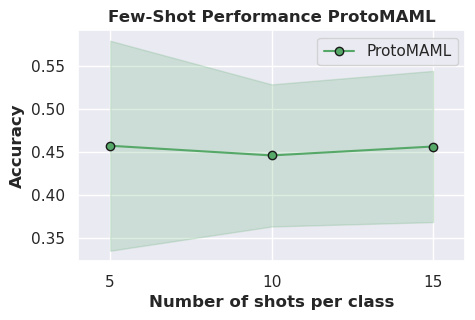

In [ ]:
plot_few_shot(protomaml_accuracies, name="ProtoMAML", color="C2", ax=None)
plt.show()
plt.close()